In [2]:
from sklearn.datasets import fetch_mldata
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
# 784 features because we're treating with 28x28 pixels images

In [6]:
y.shape

(70000,)

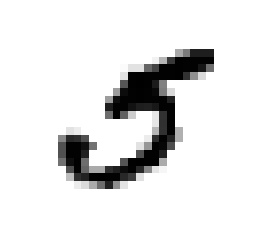

In [22]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [23]:
y[36000] # Label

5.0

In [24]:
# MNIST dataset is already split into a training set (the first 60000 images) and a test set (the last 10000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Let's shuffle the training set
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [25]:
# For now we're going to train a binary classifier (5 or not 5)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# Starting with Stochastic Gradient Descent (efficient with very large datasets)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [26]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [27]:
# It guessed right for this particular case. Let's see the model's performance.
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.96685,  0.95465,  0.9674 ])

In [28]:
# Cool! Well, actually not so much. Even if we build a simple classifier that just classifies every single image in the "not 5"
# class, we would get over 90% of accuracy.
# This is simply because only about 10% of the images are 5s
# This is why accuracy is generally not the preferred performance measure for classifiers, especially in datasets where some 
# classes are much more frequent than others.

In [29]:
# Let's try with the Confusion Matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

confusion_matrix(y_train_5, y_train_pred)

array([[53978,   601],
       [ 1621,  3800]])

In [30]:
# 53978 correctly classified as not 5s
# 601 wrongly classified as 5s
# 1621 wrongly classified as not 5s
# 3800 correctly classified as 5s

from sklearn.metrics import f1_score # harmonic means of precision and recall
f1_score(y_train_5, y_train_pred)

0.7737731622887396

In [31]:
# Because of precision/recall tradeoff we may want to set the threshold directly (SGD uses a threshold = 0)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

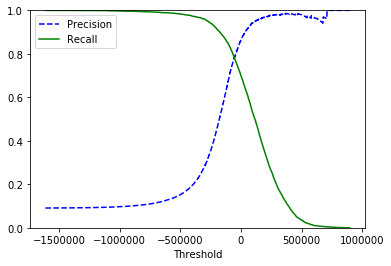

In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [33]:
# Choosing a threshold of 70000
y_train_pred_90 = (y_scores > 60000)

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred_90)

0.91888072357263995

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.59970485150341268

In [35]:
# NB! : a high-precision classifier is not very useful if its recall is too low

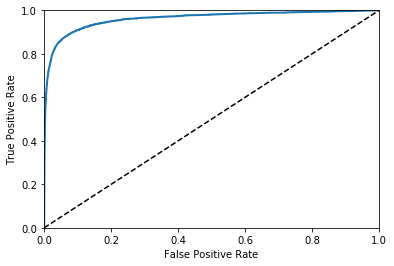

In [36]:
# ROC Curve is another method often used in binary classifiers
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [37]:
# Of course we have another tradeoff: the higher the TPR, the more FPR the classifier produces.
# A good classifier stays as far away from the dotted line as possible
# Let's see the AREA UNDER THE CURVE

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96172133575838925

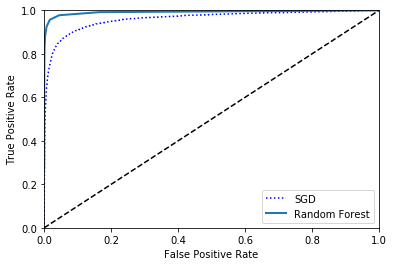

In [39]:
# Now let's train a RandomForestClassifier and compare its ROC curve score to the SGDClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# ROC curve needs score, not probabilities
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [40]:
# Looks sooo much better!
roc_auc_score(y_train_5, y_scores_forest)

0.9922637504455083

# Multiclass Classification

In [42]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [43]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [44]:
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0.1,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

In [45]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.85842831,  0.86354318,  0.84862729])

In [46]:
# Improve this result by scaling the values
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91111778,  0.90984549,  0.90858629])

In [47]:
# Error analysis

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5747,    2,   18,   10,   12,   45,   38,   10,   37,    4],
       [   1, 6450,   46,   31,    7,   48,    7,   13,  129,   10],
       [  62,   35, 5335,   96,   83,   24,   90,   49,  169,   15],
       [  50,   36,  140, 5363,    2,  216,   33,   54,  139,   98],
       [  21,   25,   31,   10, 5364,    8,   53,   27,   87,  216],
       [  77,   43,   35,  179,   77, 4592,  109,   28,  184,   97],
       [  42,   29,   47,    1,   45,   86, 5613,    4,   51,    0],
       [  19,   20,   64,   32,   56,   12,    4, 5801,   14,  243],
       [  53,  149,   67,  159,   14,  146,   56,   27, 5039,  141],
       [  47,   29,   25,   92,  150,   27,    2,  211,   79, 5287]])

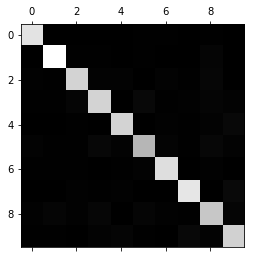

In [48]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

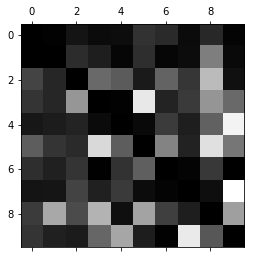

In [50]:
# Most images are on the main diagonal, so they are classified correctly, good
# Let's focus on errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# As we can see 8s and 9s are often misclassified and for example 3s and 5s are confused
# There is space for improvement!